In [1]:
require 'nn'
require 'nngraph'
require 'load_images'
require 'torch'
require 'optim'

In [2]:
-- Load data

nngraph.setDebug(true)
logger = optim.Logger('loss_log.txt')

images = load_images.load('datasets/Set14/image_SRF_4/', 'png', false)
inputChannels = 3

-- Convert greyscale images
for i = 1, #images do
        images[i] = images[i]:expand(inputChannels, images[i]:size(2), images[i]:size(3))
end

n = #images / 2

imagesLR = {}--images:select()
imagesHR = {}--images[2]

for i = 1, n do
	imagesLR[i] = images[2 * i]
	imagesHR[i] = images[2 * i - 1]
end

In [44]:
-- Make network

upscaleFactor = 4

net = nn.Sequential()
net:add(nn.SpatialConvolution(inputChannels, 6, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(6, 6, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(6, 32, 5, 5, 1, 1, 2, 2))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(32, inputChannels * upscaleFactor * upscaleFactor, 3, 3, 1, 1, 1, 1))
net:add(nn.PixelShuffle(upscaleFactor))

--net:add(nn.SpatialFullConvolution(32, 3, 9, 9, upscaleFactor, upscaleFactor, 3, 3, 1, 1))

--graph.dot(net.fg, 'cnn1', 'cnn1')

In [ ]:
-- Load network from disk
net = torch.load("upscaleDeConv.model")

In [65]:
-- Train network

criterion = nn.MSECriterion()

x, dl_dx = net:getParameters()

feval = function(x_new)
   
   if x ~= x_new then
      x:copy(x_new)
   end

   -- select a new training sample
   _nidx_ = (_nidx_ or 0) + 1
   if _nidx_ > #imagesHR then _nidx_ = 1 end

   --local sample = data[_nidx_]
   local target = imagesHR[_nidx_]      -- this funny looking syntax allows
   local inputs = imagesLR[_nidx_]    -- slicing of arrays.

   -- reset gradients (gradients are always accumulated, to accommodate 
   -- batch methods)
   dl_dx:zero()

   -- evaluate the loss function and its derivative wrt x, for that sample
   local loss_x = criterion:forward(net:forward(inputs), target)
   net:backward(inputs, criterion:backward(net.output, target))

   -- return loss(x) and dloss/dx
   return loss_x, dl_dx
end

sgd_params = {
   learningRate = 1e-1,
   learningRateDecay = 0, --1e-4,
   weightDecay = 0,
   momentum = 0
}

for i = 1,10 do

   -- this variable is used to estimate the average loss
   current_loss = 0

   -- an epoch is a full loop over our training data
   for i = 1, #imagesHR do
      
      _,fs = optim.sgd(feval,x,sgd_params)


      current_loss = current_loss + fs[1]
   end

   -- report average error on epoch
   current_loss = current_loss / #imagesHR
   print('current loss = ' .. current_loss)
   
   logger:add{['training error'] = current_loss}
   logger:style{['training error'] = '-'}
   if i%200 == 0 then
   logger:plot()  
   end
end

torch.save("upscaleDeConv.model", net)
print("Model saved")

current loss = 0.015893983241734	


current loss = 0.015724963359277	


current loss = 0.015573168399507	


current loss = 0.015436136405816	


current loss = 0.015312216606589	


current loss = 0.015199702031865	


current loss = 0.01509732359308	


current loss = 0.015003842857831	


current loss = 0.014918063599987	


current loss = 0.014839097765581	


Model saved	


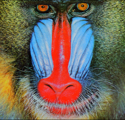

   3
 120
 125
[torch.LongStorage of size 3]



   3
 480
 500
[torch.LongStorage of size 3]



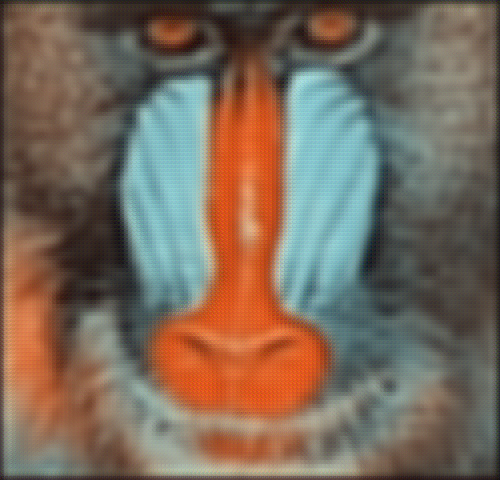

   3
 480
 500
[torch.LongStorage of size 3]



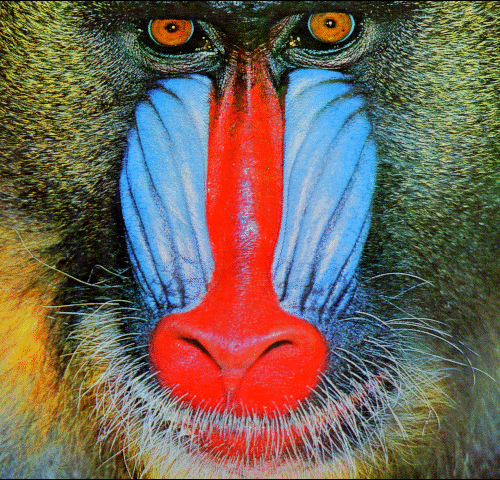

In [69]:
-- Test example

imgselector = 1

local origin = imagesLR[imgselector]
local gt = imagesHR[imgselector]
local test = net:forward(origin)

image.save("test.png", test)

itorch.image(origin)
print(origin:size())

itorch.image(test)
print(test:size())

itorch.image(gt)
print(gt:size())

In [43]:
print(net)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): nn.SpatialConvolution(3 -> 6, 3x3, 1,1, 1,1)
  (2): nn.ReLU
  (3): nn.SpatialConvolution(6 -> 6, 3x3, 1,1, 1,1)
  (4): nn.ReLU
  (5): nn.SpatialConvolution(6 -> 6, 3x3, 1,1, 1,1)
  (6): nn.ReLU
  (7): nn.SpatialConvolution(6 -> 6, 3x3, 1,1, 1,1)
  (8): nn.ReLU
  (9): nn.SpatialConvolution(6 -> 32, 3x3, 1,1, 1,1)
  (10): nn.ReLU
  (11): nn.SpatialConvolution(32 -> 48, 3x3, 1,1, 1,1)
  (12): nn.PixelShuffle
}
{


  gradInput : DoubleTensor - size: 3x97x146
  modules : 
    {
      1 : 
        nn.SpatialConvolution(3 -> 6, 3x3, 1,1, 1,1)
        {
          padW : 1


          nInputPlane : 3
        

  output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 3x97x146
          _type : torch.DoubleTensor
          dH : 1
        

  dW : 1
          nOutputPlane : 6
          padH : 1
          kH : 3
          

finput : DoubleTensor - size: 27x15000
          weight : DoubleTensor - size: 6x3x3x3


          gradWeight : DoubleTensor - size: 6x3x3x3


        fgradInput : DoubleTensor - size: 27x14162
          kW : 3


          bias : DoubleTensor - size: 6
          gradBias : DoubleTensor - size: 6
        }
  

    2 : 
        nn.ReLU
        {
          inplace : false


          threshold : 0
          _type : torch.DoubleTensor
         

 output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 6x97x146
          

val : 0
        }
      3 : 
        nn.SpatialConvolution(6 -> 6, 3x3, 1,1, 1,1)
    

    {
          padW : 1
          nInputPlane : 6


          output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 6x97x146
          _type : torch.DoubleTensor
          dH : 1
          dW : 1
          nOutputPlane : 6
          padH : 1
          kH : 3
          finput : DoubleTensor - size: 54x15000
          weight : DoubleTensor - size: 6x6x3x3
          gradWeight : DoubleTensor - size: 6x6x3x3
          fgradInput : DoubleTensor - size: 54x14162
          kW : 3
          bias : DoubleTensor - size: 6
          gradBias : DoubleTensor - size: 6
        }
      4 : 
        nn.ReLU
        {


          inplace : false
          threshold : 0
          _type : torch.DoubleTensor
          output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 6x97x146
          val : 0
        }
      5 : 
        nn.SpatialConvolution(6 -> 6, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 6
          output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 6x97x146
          _type : torch.DoubleTensor
          dH : 1
          dW : 1
          nOutputPlane : 6
          padH : 1
          kH : 3
          finput : DoubleTensor - size: 54x15000
          weight : DoubleTensor - size: 6x6x3x3
          gradWeight : DoubleTensor - size: 6x6x3x3
          fgradInput : DoubleTensor - size: 54x14162
          kW : 3
          bias : DoubleTensor - size: 6
          gradBias : DoubleTensor - size: 6
        }
      6 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          _type : torch.Doub

          gradBias : DoubleTensor - size: 6
        }
      8 : 
        nn.ReLU


        {
          inplace : false
          threshold : 0
          _type : torch.DoubleTensor
          output : DoubleTensor - size: 6x120x125
          gradInput : DoubleTensor - size: 6x97x146
          val : 0
        }
      9 : 
        nn.SpatialConvolution(6 -> 32, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 6
          output : DoubleTensor - size: 32x120x125
          gradInput : DoubleTensor - size: 6x97x146
          _type : torch.DoubleTensor
          dH : 1
          dW : 1
          nOutputPlane : 32
          padH : 1
          kH : 3
          finput : DoubleTensor - size: 54x15000
          weight : DoubleTensor - size: 32x6x3x3
          gradWeight : DoubleTensor - size: 32x6x3x3
          fgradInput : DoubleTensor - size: 54x14162
          kW : 3
          bias : DoubleTensor - size: 32
          gradBias : DoubleTensor - size: 32
        }
      10 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          